In [1]:
import cv2,os
from skimage import io
import numpy as np
from tqdm import tqdm 
from matplotlib import pyplot as plt

# Read Path 

In [10]:
path_Ctrl = "../../Datasets/221206SoRa/Single_Ctrl/60x_4x_Dapi_test_50nmSTP006/"
path_VPA = "../../Datasets/221206SoRa/Single_VPA/VPA_555CTCF_488H3K27AC_DAPI_003/"

In [11]:
DataPath_Ctrl=[]

for root,dirs,files in os.walk(path_Ctrl):
    for file_name in files:
        path = os.path.join(root,file_name)
        label = os.path.join(file_name)
        DataPath_Ctrl.append(path)
        
print("len(DataPath_Ctrl):",len(DataPath_Ctrl))

############################################################

DataPath_VPA=[]

for root,dirs,files in os.walk(path_VPA):
    for file_name in files:
        path = os.path.join(root,file_name)
        label = os.path.join(file_name)
        DataPath_VPA.append(path)
        
print("len(DataPath_VPA):",len(DataPath_VPA))

len(DataPath_Ctrl): 1780
len(DataPath_VPA): 1805


*********

# Read Image

In [14]:
img_Ctrl=[]
for i in tqdm(range(len(DataPath_Ctrl))):
    img = io.imread(DataPath_Ctrl[i])
    img_Ctrl.append(img)
    
img_Ctrl = np.array(img_Ctrl,'dtype=object')
np.save("img_Ctrl.npy",img_Ctrl,'dtype=object')

100%|██████████████████████████████████████████████████████| 1780/1780 [01:10<00:00, 25.34it/s]
/home/acd13264yb/python7_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [15]:
img_VPA=[]
for i in tqdm(range(len(DataPath_VPA))):
    img = io.imread(DataPath_VPA[i])
    img_VPA.append(img)
    
img_VPA = np.array(img_VPA,'dtype=object')
np.save("img_VPA.npy",img_VPA,'dtype=object')

100%|██████████████████████████████████████████████████████| 1805/1805 [01:00<00:00, 29.91it/s]
/home/acd13264yb/python7_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


*********

# Data preprocessing

In [17]:
Data_Ctrl=np.load("img_Ctrl.npy",allow_pickle=True)
Data_VPA=np.load("img_VPA.npy",allow_pickle=True)
print("img_Ctrl.shape:", Data_Ctrl.shape)
print("img_VPA.shape:", Data_VPA.shape)

img_Ctrl.shape: (1780,)
img_VPA.shape: (1805,)


In [30]:
min(min(shapeX,shapeY))

163

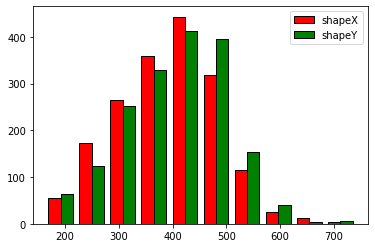

In [31]:
shapeX=[]
shapeY=[]
for i in range(len(Data_Ctrl)):
    shapeX.append(Data_Ctrl[i].shape[0])
    shapeY.append(Data_Ctrl[i].shape[1])
fig, ax = plt.subplots()
ax.hist([shapeX,shapeY], label=["shapeX", "shapeY"], color=["r", "g"], ec="k",range=[min(min(shapeX,shapeY)),max(max(shapeX,shapeY))])
ax.legend()

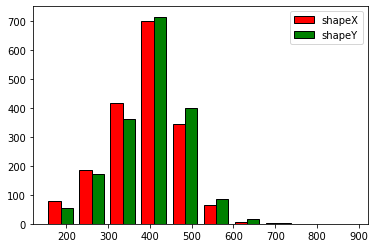

In [32]:
shapeX=[]
shapeY=[]
for i in range(len(Data_VPA)):
    shapeX.append(Data_VPA[i].shape[0])
    shapeY.append(Data_VPA[i].shape[1])
fig, ax = plt.subplots()
ax.hist([shapeX,shapeY], label=["shapeX", "shapeY"], color=["r", "g"], ec="k",range=[min(min(shapeX,shapeY)),max(max(shapeX,shapeY))])
ax.legend()

## padding 

In [33]:
#　同じサイズにする
def datapadding(img):
    imgSize = img.shape
    top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2
    left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2
    if (imgSize[0] % 2) != 0:
        top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2+1
    if (imgSize[1] % 2) != 0:     
        left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2+1
    img_pad = cv2.copyMakeBorder(img,top_size,bottom_size,left_size,right_size,cv2.BORDER_CONSTANT,value=(0,0,0))
    return img_pad

In [35]:
Max_shape_0=512
Max_shape_1=512
min_shape_0=300
min_shape_1=300

In [36]:
num=0
final_01=[]
for n in range(len(Data_Ctrl)):
    img = Data_Ctrl[n]
    if min_shape_0<=img.shape[0]<=Max_shape_0 and min_shape_1<=img.shape[1]<=Max_shape_1:
        num+=1
        final_01.append(datapadding(img))
final_01=np.array(final_01)
np.save("Ctrl_pad.npy",final_01)
print(final_01.shape)


num=0
final_02=[]
for n in range(len(Data_VPA)):
    img = Data_VPA[n]
    if min_shape_0<=img.shape[0]<=Max_shape_0 and min_shape_1<=img.shape[1]<=Max_shape_1:
        num+=1
        final_02.append(datapadding(img))
final_02=np.array(final_02)
np.save("VPA_pad.npy",final_02)
print(final_02.shape)

(1056, 512, 512, 3)
(1199, 512, 512, 3)


# split train and test

In [2]:
def NormToUnit8(img):
    img_uint8 = img - img.min()
    img_uint8 = img_uint8 / (img_uint8.max() - img_uint8.min())
    img_uint8 *= 255
    return img_uint8.astype(np.uint8)

In [12]:
Data_Ctrl=np.load("Ctrl_pad.npy",allow_pickle=True)
Data_VPA=np.load("VPA_pad.npy",allow_pickle=True)

print("Data_Ctrl.shape:", Data_Ctrl.shape, " dtype: ", Data_Ctrl.dtype)
print("Data_VPA.shape:", Data_VPA.shape, " dtype: ", Data_VPA.dtype)

Data_Ctrl.shape: (1056, 512, 512, 3)  dtype:  uint16
Data_VPA.shape: (1199, 512, 512, 3)  dtype:  uint16


In [13]:
Data_Ctrl_unit8=[]
for img in Data_Ctrl:
    Data_Ctrl_unit8.append(NormToUnit8(img))
Data_Ctrl_unit8=np.array(Data_Ctrl_unit8)
np.save("Ctrl_pad_unit8.npy",Data_Ctrl_unit8)
print("Data_Ctrl_unit8.shape:", Data_Ctrl_unit8.shape, " dtype: ", Data_Ctrl_unit8.dtype)

Data_VPA_unit8=[]
for img in Data_VPA:
    Data_VPA_unit8.append(NormToUnit8(img))
Data_VPA_unit8=np.array(Data_VPA_unit8)
np.save("VPA_pad_unit8.npy",Data_VPA_unit8)
print("Data_VPA_unit8.shape:", Data_VPA_unit8.shape, " dtype: ", Data_VPA_unit8.dtype)

Data_Ctrl_unit8.shape: (1056, 512, 512, 3)  dtype:  uint8
Data_VPA_unit8.shape: (1199, 512, 512, 3)  dtype:  uint8
